In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import SplineTransformer

import optuna as optuna
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import FeatureAgglomeration
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.svm import SVC

import cv2 as cv2
from skimage.color import rgb2gray
from skimage.feature import hog, graycomatrix, graycoprops
from skimage.filters import gabor_kernel, gabor
from skimage.measure import label, regionprops
from skimage import img_as_float32
from skimage.transform import resize

from joblib import Parallel, delayed
from multiprocessing import Pool


c:\Users\domin\miniforge3\envs\ML1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('mnist_train.csv')
test  = pd.read_csv('mnist_test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


# Preprocessing

### One hot encoding

In [3]:
encoder = OneHotEncoder()

train_target = train['label']
test_target = test['label']

train_values = train.drop('label', axis=1)
test_values = test.drop('label', axis=1)

train_values = train_values.values.reshape(-1, 28, 28) 
test_values = test_values.values.reshape(-1, 28, 28)

train_target_encoded = encoder.fit_transform(train_target.values.reshape(-1, 1)).toarray()
test_target_encoded = encoder.transform(test_target.values.reshape(-1, 1)).toarray()

print("Shape of train_values:", train_values.shape)
print("Shape of train_target_encoded:", train_target_encoded.shape)

print("Shape of test_values:", test_values.shape)
print("Shape of test_target_encoded:", test_target_encoded.shape)

Shape of train_values: (60000, 28, 28)
Shape of train_target_encoded: (60000, 10)
Shape of test_values: (10000, 28, 28)
Shape of test_target_encoded: (10000, 10)


In [4]:
X_train = train_values
X_train = train_values.astype(np.uint8)

y_train_ENC = train_target_encoded
y_train = np.argmax(y_train_ENC, axis=1)

X_test = test_values
X_test = test_values.astype(np.uint8)

y_test_ENC = test_target_encoded
y_test = np.argmax(y_test_ENC, axis=1)

### Normalizacja histogramem

In [5]:
# # Sprawdzenie i konwersja typu danych
# if X_train.dtype != np.uint8:
#     X_train = X_train.astype(np.float32)
# if X_test.dtype != np.uint8:
#     X_test = X_test.astype(np.float32)

# Sprawdzenie i ewentualna korekta kształtu danych
if X_train.shape[1:] != (28, 28):
    X_train = X_train.reshape(-1, 28, 28)
if X_test.shape[1:] != (28, 28):
    X_test = X_test.reshape(-1, 28, 28)

# Wyrównywanie histogramu
for i in range(X_train.shape[0]):
    X_train[i] = cv2.equalizeHist(X_train[i])

for i in range(X_test.shape[0]):
    X_test[i] = cv2.equalizeHist(X_test[i])

### Powiększanie i wygładzenie obrazu

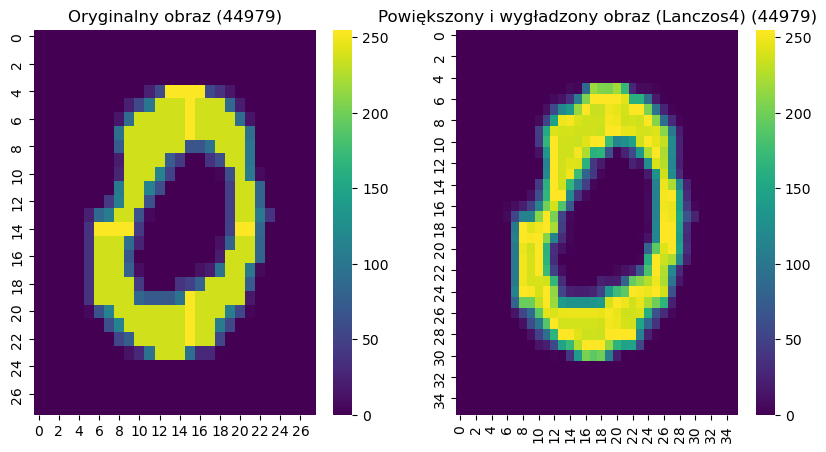

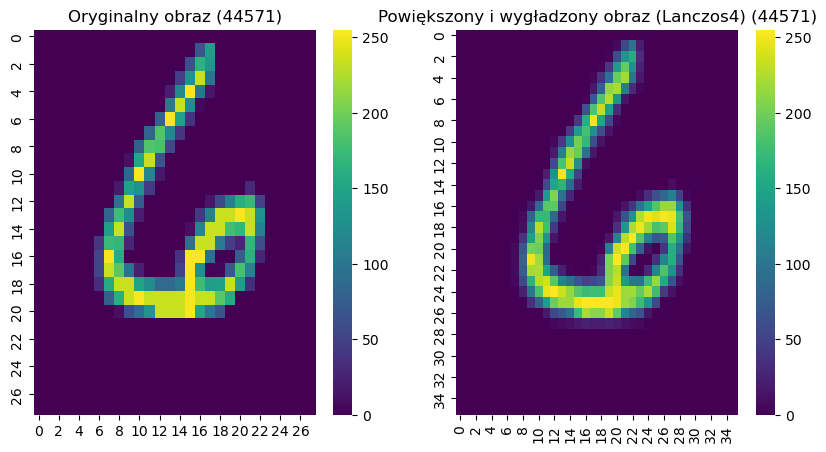

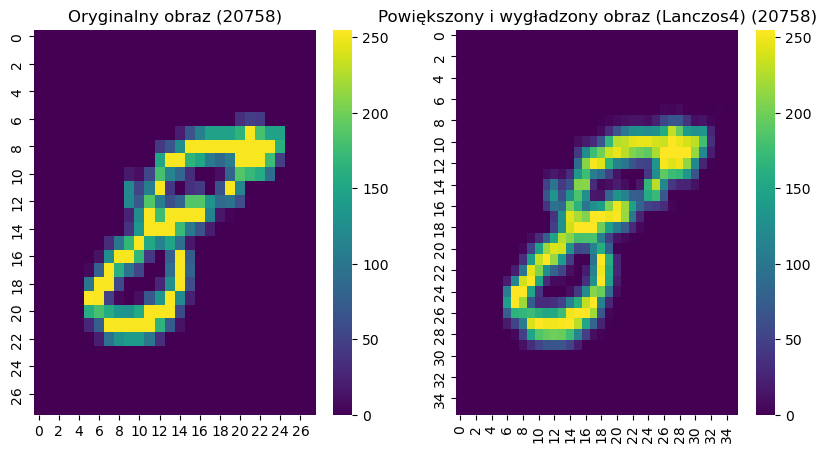

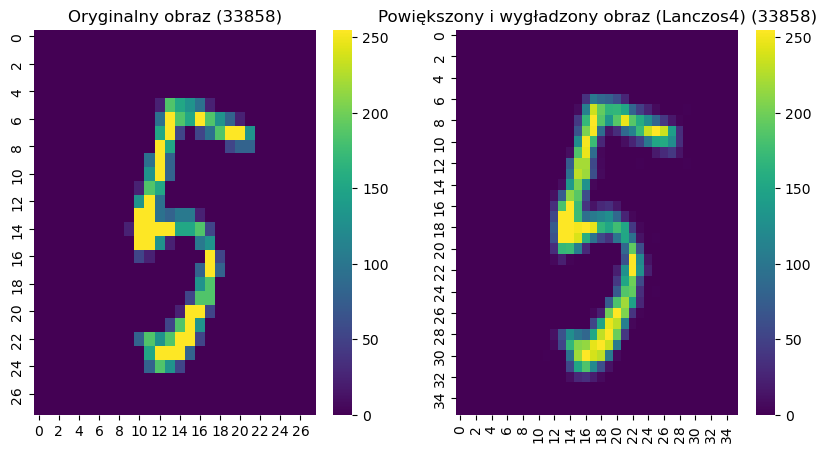

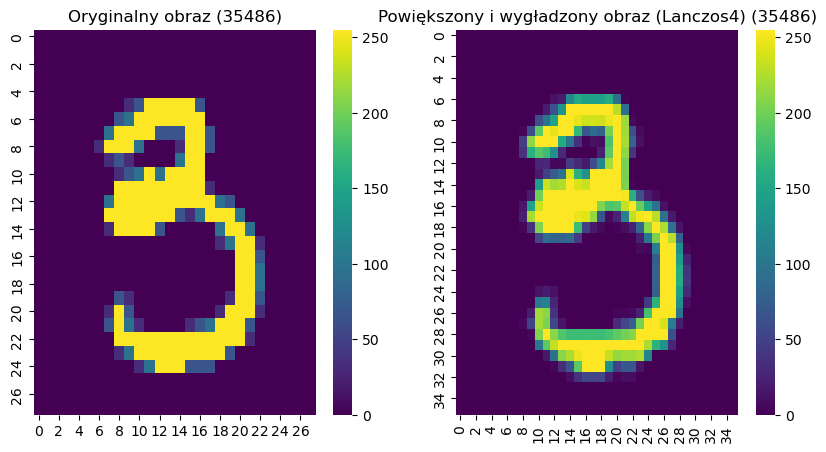

In [6]:
def enlarge_and_smooth(image, new_size):
    """Powiększa obraz za pomocą interpolacji bicubic."""
    enlarged_image = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)
    return enlarged_image

# Sztuczne zwiększenie rozmiaru obrazu 
sample_indices = np.random.choice(X_train.shape[0], 5, replace=False)

# Dla każdego wybranego obrazu
for idx in sample_indices:
    # Oryginalny obraz
    original_image = X_train[idx]

    # Powiększony i wygładzony obraz
    enlarged_smoothed_image = enlarge_and_smooth(original_image, new_size=(36, 36))

    # Wyświetl oryginalny i przekształcony obraz obok siebie
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    sns.heatmap(original_image, cmap="viridis", ax=axes[0])
    axes[0].set_title(f'Oryginalny obraz ({idx})')

    sns.heatmap(enlarged_smoothed_image, cmap="viridis", ax=axes[1])
    axes[1].set_title(f'Powiększony i wygładzony obraz (Lanczos4) ({idx})')

    plt.show()

### Sprawdzenie modelu wykorzystując SVC dla danych orginalnaych

AUC: 0.9998


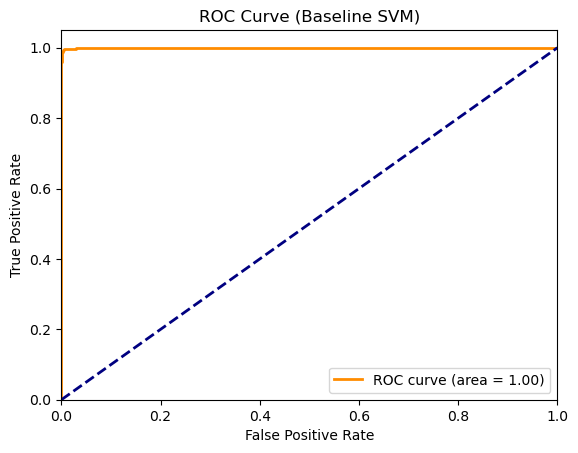


Metryki w formie tabeli:


,QDA,SVM
Accuracy,0.789333,0.977750
Precision,0.824861,0.977794
Recall,0.787770,0.977738
F1-score,0.789385,0.977751



Metryki w formie tabeli:


,QDA,SVM
Accuracy,0.789333,0.977750
Precision,0.824861,0.977794
Recall,0.787770,0.977738
F1-score,0.789385,0.977751



QDA - Confusion Matrix:


Przewidywana klasa,0,1,2,3,4,5,6,7,8,9
Prawdziwa klasa,,,,,,,,,,
0,1111,1,17,5,1,2,8,2,20,0
1,1,1164,16,13,6,8,15,4,49,5
2,28,7,969,48,11,0,22,2,116,1
3,32,15,35,871,0,11,11,12,214,32
4,10,2,40,7,798,4,11,17,71,258
5,52,5,13,63,5,578,30,5,292,29
6,12,7,16,4,0,13,1065,0,27,1
7,5,4,12,25,27,0,0,760,19,398
8,24,46,22,21,8,14,6,5,1022,20



SVM - Confusion Matrix:


Przewidywana klasa,0,1,2,3,4,5,6,7,8,9
Prawdziwa klasa,,,,,,,,,,
0,1160,0,3,0,1,1,1,0,1,0
1,0,1269,4,1,2,0,1,2,1,1
2,8,2,1174,4,3,0,3,3,7,0
3,0,2,9,1196,0,8,0,2,11,5
4,1,1,1,0,1191,0,5,1,2,16
5,2,1,1,11,2,1041,10,0,3,1
6,6,1,0,0,2,3,1131,0,2,0
7,0,6,8,2,3,0,1,1217,2,11
8,1,8,5,6,5,5,3,1,1149,5



QDA - Classification Report:


,precision,recall,f1-score,support
0,0.868647,0.952014,0.908422,1167.000000
1,0.926752,0.908665,0.917619,1281.000000
2,0.842609,0.804817,0.823280,1204.000000
3,0.817840,0.706407,0.758050,1233.000000
4,0.908884,0.655172,0.761450,1218.000000
5,0.914557,0.539179,0.678404,1072.000000
6,0.911815,0.930131,0.920882,1145.000000
7,0.901542,0.608000,0.726230,1250.000000
8,0.552134,0.860269,0.672590,1188.000000
9,0.603834,0.913043,0.726923,1242.000000



SVM - Classification Report:


,precision,recall,f1-score,support
0,0.983051,0.994002,0.988496,1167.00000
1,0.980680,0.990632,0.985631,1281.00000
2,0.973466,0.975083,0.974274,1204.00000
3,0.976327,0.969992,0.973149,1233.00000
4,0.977833,0.977833,0.977833,1218.00000
5,0.981150,0.971082,0.976090,1072.00000
6,0.979221,0.987773,0.983478,1145.00000
7,0.983832,0.973600,0.978689,1250.00000
8,0.973729,0.967172,0.970439,1188.00000
9,0.968650,0.970209,0.969429,1242.00000


In [7]:
# Baseline accuracy without transformations
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    X_train, y_train, test_size=0.2, random_state=69)

qda_base = QDA(reg_param=0.1)
qda_base.fit(X_train_base.reshape(X_train_base.shape[0], -1),
              y_train_base) 
y_pred_qda_base = qda_base.predict(X_val_base.reshape(X_val_base.shape[0], -1))

svm_base = SVC(probability=True)
svm_base.fit(X_train_base.reshape(X_train_base.shape[0], -1),
              y_train_base)  
y_pred_svm_base = svm_base.predict(X_val_base.reshape(X_val_base.shape[0], -1))

# ROC i AUC
y_prob_svm_base = svm_base.predict_proba(X_val_base.reshape(X_val_base.shape[0], -1))
fpr, tpr, thresholds = roc_curve(y_val_base,
                                 y_prob_svm_base[:, 1],
                                 pos_label=1)
roc_auc = auc(fpr, tpr)

# Funkcja do obliczania i wyświetlania metryk
def evaluate_model(model_name, y_true, y_pred, y_prob=None):
    """Oblicza i wyświetla metryki modelu."""
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='macro'),
        "Recall": recall_score(y_true, y_pred, average='macro'),
        "F1-score": f1_score(y_true, y_pred, average='macro')
    }

    #print(f"\n{model_name}:")
    #for metric, value in metrics.items():
    #    print(f"{metric}: {value:.4f}")

    #print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    #print("Classification report:\n",
    #      classification_report(y_true, y_pred))

    if y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_true, y_prob[:, 1], pos_label=1)
        roc_auc = auc(fpr, tpr)
        print(f"AUC: {roc_auc:.4f}")

        # Wizualizacja krzywej ROC
        plt.figure()
        plt.plot(fpr,
                 tpr,
                 color='darkorange',
                 lw=2,
                 label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve ({model_name})')
        plt.legend(loc="lower right")
        plt.show()


# Wywołanie funkcji evaluate_model dla QDA i SVM
evaluate_model("Baseline QDA", y_val_base, y_pred_qda_base)
evaluate_model("Baseline SVM", y_val_base, y_pred_svm_base, y_prob_svm_base)

# Tworzenie DataFrame z metrykami
metrics_df = pd.DataFrame({
    "QDA": [
        accuracy_score(y_val_base, y_pred_qda_base),
        precision_score(y_val_base, y_pred_qda_base, average='macro'),
        recall_score(y_val_base, y_pred_qda_base, average='macro'),
        f1_score(y_val_base, y_pred_qda_base, average='macro')
    ],
    "SVM": [
        accuracy_score(y_val_base, y_pred_svm_base),
        precision_score(y_val_base, y_pred_svm_base, average='macro'),
        recall_score(y_val_base, y_pred_svm_base, average='macro'),
        f1_score(y_val_base, y_pred_svm_base, average='macro')
    ]
},
                            index=["Accuracy", "Precision", "Recall", "F1-score"])

# Wyświetlanie DataFrame
print("\nMetryki w formie tabeli:")
display(metrics_df)

# Funkcja do tworzenia DataFrame z macierzy pomyłek
def confusion_matrix_df(y_true, y_pred):
    """Tworzy DataFrame z macierzy pomyłek."""
    cm = confusion_matrix(y_true, y_pred)
    labels = sorted(np.unique(y_true))
    df = pd.DataFrame(cm, index=labels, columns=labels)
    df.index.name = 'Prawdziwa klasa'
    df.columns.name = 'Przewidywana klasa'
    return df

# Funkcja do wyświetlania raportu klasyfikacji w formie DataFrame
def classification_report_df(y_true, y_pred):
    """Tworzy DataFrame z raportu klasyfikacji."""
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    return df

# Wyświetlanie DataFrame z metrykami
print("\nMetryki w formie tabeli:")
display(metrics_df)

# Wyświetlanie macierzy pomyłek jako DataFrame
print("\nQDA - Confusion Matrix:")
display(confusion_matrix_df(y_val_base, y_pred_qda_base))
print("\nSVM - Confusion Matrix:")
display(confusion_matrix_df(y_val_base, y_pred_svm_base))

# Wyświetlanie raportu klasyfikacji jako DataFrame
print("\nQDA - Classification Report:")
display(classification_report_df(y_val_base, y_pred_qda_base))
print("\nSVM - Classification Report:")
display(classification_report_df(y_val_base, y_pred_svm_base))

Baseline QDA accuracy: 0.789

Baseline SVM accuracy: 0.9793

### Sprawdzenie modelu wykorzystując SVC dla danych upscalowanych

In [21]:
smoothed_X_train = np.array([enlarge_and_smooth(image, new_size=(36, 36)) for image in X_train])

# Baseline accuracy without transformations
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    smoothed_X_train, y_train, test_size=0.2, random_state=69)

qda_base = QDA(reg_param=0.1)
qda_base.fit(X_train_base.reshape(X_train_base.shape[0], -1), y_train_base)
y_pred_qda_base = qda_base.predict(
    X_val_base.reshape(X_val_base.shape[0], -1))
accuracy_qda_base = accuracy_score(y_val_base, y_pred_qda_base)

svm_base = SVC()
svm_base.fit(X_train_base.reshape(X_train_base.shape[0], -1), y_train_base)
y_pred_svm_base = svm_base.predict(
    X_val_base.reshape(X_val_base.shape[0], -1))
accuracy_svm_base = accuracy_score(y_val_base, y_pred_svm_base)

print("Baseline QDA accuracy:", accuracy_qda_base)
print("Baseline SVM accuracy:", accuracy_svm_base)

Baseline QDA accuracy: 0.8069166666666666
Baseline SVM accuracy: 0.9789166666666667


Baseline QDA accuracy: 0.8069

Baseline SVM accuracy: 0.9789

# Deklaracja funkcji dla ekstrakcji cech z obrazu

In [9]:

def calculate_hog_parallel(images, orientations=None, pixels_per_cell=None, cells_per_block=None, n_jobs=-1):
    """Oblicza deskryptory HOG dla obrazu."""
    
     # Ustawienie wartości domyślnych, jeśli parametry nie są podane
    if orientations is None:
        orientations = 9
    if pixels_per_cell is None:
        pixels_per_cell = (8, 8)
    if cells_per_block is None:
        cells_per_block = (2, 2)
    
    def calculate_hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block):
        
        image = img_as_float32(image)

        fd = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block, visualize=False, channel_axis=None)

        return fd
    
    return Parallel(n_jobs=n_jobs)(delayed(calculate_hog)(image, orientations, pixels_per_cell, cells_per_block) for image in images)


def apply_gabor_filters_parallel(images, thetas=None, sigmas=None, frequencies=None, n_jobs=-1):
    """
    Stosuje filtry Gabora do wielu obrazów równolegle.

    Argumenty:
        images: Lista obrazów wejściowych.
        thetas: (Opcjonalnie) Lista kątów orientacji filtrów Gabora (w radianach). Jeśli None, używane są wartości domyślne.
        sigmas: (Opcjonalnie) Lista odchyleń standardowych filtrów Gabora. Jeśli None, używane są wartości domyślne.
        frequencies: (Opcjonalnie) Lista częstotliwości przestrzennych filtrów Gabora. Jeśli None, używane są wartości domyślne.
        n_jobs: Liczba rdzeni procesora do wykorzystania podczas zrównoleglania. -1 oznacza użycie wszystkich dostępnych rdzeni.

    Zwraca:
        Listę tablic NumPy zawierających obrazy przefiltrowane filtrami Gabora, o typie danych float32.
    """

    # Ustawienie wartości domyślnych, jeśli parametry nie są podane
    if thetas is None:
        thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    if sigmas is None:
        sigmas = [1, 3]
    if frequencies is None:
        frequencies = [0.05, 0.25]

    def apply_gabor_filters_single(image):
        image = img_as_float32(image)
        filtered_images = [gabor(image, frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)[0]
                           for theta in thetas for sigma in sigmas for frequency in frequencies]
        return np.array(filtered_images, dtype=np.float32)

    return Parallel(n_jobs=n_jobs)(delayed(apply_gabor_filters_single)(image) for image in images)


def extract_features_HOG_Gabor(X, hog_orientations=None, hog_pixels_per_cell=None, hog_cells_per_block=None, 
                              gabor_thetas=None, gabor_sigmas=None, gabor_frequencies=None):
    """Generator zwracający cechy HOG i Gabora dla obrazów."""

    hog_features_list = calculate_hog_parallel(X, orientations=hog_orientations, pixels_per_cell=hog_pixels_per_cell, cells_per_block=hog_cells_per_block)
    gabor_features_list = apply_gabor_filters_parallel(X, thetas=gabor_thetas, sigmas=gabor_sigmas, frequencies=gabor_frequencies)

    for hog_features, gabor_features in zip(hog_features_list, gabor_features_list):
        
        gabor_features_flattened = np.array([img.flatten() for img in gabor_features])

        # Dopasowujemy kształt hog_features do gabor_features_flattened
        hog_features_reshaped = np.repeat(hog_features.reshape(1, -1), gabor_features_flattened.shape[0], axis=0)

        # Łączymy cechy HOG i Gabora w poziomie
        concatenated_features = np.hstack((hog_features_reshaped, gabor_features_flattened))

        concatenated_features = concatenated_features.flatten()

        yield concatenated_features

#################################################################################################################################################
################################################  Directional filters, ORB    ###################################################################

def apply_directional_filters(image, kernel_sizes=[3, 5]):
    """Stosuje filtry kierunkowe do obrazu."""
    filtered_images = []

    # Wykrywanie krawędzi filtrem Canny'ego
    edges = cv2.Canny(image, 50, 150)

    def process_kernel(kernel_size):
        if kernel_size % 2 == 0 or kernel_size > 31:
            raise ValueError(
                f"Nieprawidłowy rozmiar jądra: {kernel_size}. Rozmiar jądra musi być nieparzysty i nie większy niż 31."
            )
        kernel_horizontal = cv2.getDerivKernels(1, 0, kernel_size,
                                               normalize=True)
        kernel_vertical = cv2.getDerivKernels(0, 1, kernel_size,
                                             normalize=True)
        filtered = cv2.sepFilter2D(edges, cv2.CV_32F, kernel_horizontal[0],
                                  kernel_vertical[0])
        return filtered.flatten()

    with Pool() as pool:
        filtered_images = pool.map(process_kernel, kernel_sizes)

    # Analiza składowych spójnych
    labels = label(edges)
    props = regionprops(labels)
    features = [prop.area for prop in props]

    return np.concatenate(
        [np.array(filtered_images).squeeze(), np.array(features)])


def extract_orb_features(image, nfeatures=100):
    """Wyodrębnia cechy ORB z obrazu."""
    orb = cv2.ORB_create(nfeatures=nfeatures,
                         fastThreshold=12,
                         edgeThreshold=12)
    keypoints, descriptors = orb.detectAndCompute(image, None)
    if descriptors is None:
        return []
    return descriptors.flatten()


def extract_combined_features(image, kernel_sizes=[3, 5], nfeatures=100):
    """Łączy cechy z filtrów kierunkowych i ORB."""
    directional_features = apply_directional_filters(image, kernel_sizes)
    orb_features = extract_orb_features(image, nfeatures)

    # Łączenie cech
    combined_features = np.concatenate((directional_features, orb_features))

    return combined_features
   



#################################################################################################################################################
################################################  GLCM, Zernike    ##############################################################################
def extract_glcm_features(image, distances=[1], angles=[0], properties=['contrast', 'energy', 'homogeneity', 'correlation']):
    """Wyodrębnia cechy GLCM z obrazu."""
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    features = []
    for prop in properties:
        features.extend(graycoprops(glcm, prop).flatten())

    return np.array(features)


## Testowanie modelu dla HOG i filtrów Gabora i porównanie wydajności przy zastosowaniu redukcji wymiarów. 

In [10]:
# def train_and_evaluate_models(X_train, y_train, use_pca=True):
#     """
#     Trenuje i ocenia modele QDA i SVC, opcjonalnie z redukcją wymiarów PCA.

#     Argumenty:
#         X_train: Dane treningowe.
#         y_train: Etykiety treningowe.
#         use_pca: Flaga wskazująca, czy używać PCA (domyślnie True).
#     """

#     # Ekstrakcja cech HOG i Gabor za pomocą generatora
#     X_train_features = np.array(list(extract_features_HOG_Gabor(X_train)))

#     # Podział na zbiór treningowy i walidacyjny
#     X_train, X_val, y_train, y_val = train_test_split(X_train_features, y_train, test_size=0.2, random_state=69)

#     # Redukcja wymiarów (opcjonalnie)
#     if use_pca:
#         pca_dim = PCA(n_components=50)
#         X_train = pca_dim.fit_transform(X_train)
#         X_val = pca_dim.transform(X_val)

#     # Tworzenie i trenowanie modelu QDA
#     qda = QDA()
#     qda.fit(X_train, y_train)

#     # Tworzenie i trenowanie modelu SVC
#     svc = SVC(kernel='rbf')
#     svc.fit(X_train, y_train)

#     # Ocena modelu
#     y_pred_qda = qda.predict(X_val)
#     accuracy_qda = accuracy_score(y_val, y_pred_qda)

#     y_pred_svc = svc.predict(X_val)
#     accuracy_svc = accuracy_score(y_val, y_pred_svc)

#     print("Dokładność QDA HOG i Gabor", "po PCA:" if use_pca else ":", accuracy_qda)
#     print("Dokładność SVC HOG i Gabor", "po PCA:" if use_pca else ":", accuracy_svc)

# # Test z PCA
# train_and_evaluate_models(X_train, y_train, use_pca=True)
#train_and_evaluate_models(X_train, y_train, use_pca=False)
#cProfile.run('train_and_evaluate_models(X_train, y_train, use_pca=True)') 

Dokładność QDA HOG i Gabor       : 0.5734


Dokładność SVC HOG i Gabor       : 0.987





Dokładność QDA HOG i Gabor po PCA: 0.9701


Dokładność SVC HOG i Gabor po PCA: 0.9869

Czas obliczeń dla PCA 3min vs 30min bez PCA

## OPTUNA dla HOG, Gabor, PCA

In [11]:
# import warnings
# warnings.filterwarnings("ignore", module="optuna")


# def objective(trial, X_train, y_train):
#     """
#     Funkcja celu dla optymalizacji Optuna. 
#     Przyjmuje próbę (trial), dane treningowe (X_train) i etykiety (y_train).
#     Zwraca dokładność QDA i SVM na danych walidacyjnych po zastosowaniu sekwencji transformacji.
#     """

#     # Parametry HOG
#     orientations      = trial.suggest_int("hog_orientations", 2, 16)
#     pixels_per_cell   = trial.suggest_categorical("hog_pixels_per_cell", [str((2, 2)), str((2, 3)), str((3, 2)), str((3, 3)), str((4, 4)), str((5, 5)),str((6, 6)), str((7, 7))])
#     cells_per_block   = trial.suggest_categorical("hog_cells_per_block", [str((1, 1)), str((2, 2)), str((3, 3)), str((4, 4))])

#     # Parametry filtrów Gabora
#     gabor_thetas      = trial.suggest_categorical("gabor_thetas", ([0],  [np.pi / 14],  [np.pi / 12], [0, np.pi / 14 ], [0, np.pi / 12 ] ))
#     gabor_sigmas      = trial.suggest_categorical("gabor_sigmas", ([0.33], [0.66], [1], [0.33 , 1.25], [0.66, 2.35], [1, 3]))
#     gabor_frequencies = trial.suggest_categorical("gabor_frequencies", ([0.025], [0.05], [0.125], [0.025, 0.125], [0.05, 0.175], [0.05, 0.25]))
        
#     #PCA
#     PCA_n_components  =  trial.suggest_int("PCA_Components", 4, 228)
#     kernel = trial.suggest_categorical("kernel_pca_kernel", ['linear', 'poly', 'rbf', 'sigmoid', 'cosine'])
#     gamma = None
#     if kernel in ['poly', 'rbf']:
#         gamma = trial.suggest_loguniform("kernel_pca_gamma", 0.001, 1)
        
#     # Powiększanie i wygładzanie
#     # X_train_split = np.array([enlarge_and_smooth(img, new_size) for img in X_train])
#     # X_val = np.array([enlarge_and_smooth(img, new_size) for img in X_val])
    
#     # Ekstrakcja cech HOG i Gabor
#     X_train_features = np.array(list(extract_features_HOG_Gabor(
#         X_train, 
#         hog_orientations=orientations, 
#         hog_pixels_per_cell=eval(pixels_per_cell), # Konwersja stringa na krotkę
#         hog_cells_per_block=eval(cells_per_block),  # Konwersja stringa na krotkę
#         gabor_thetas=gabor_thetas, 
#         gabor_sigmas=gabor_sigmas, 
#         gabor_frequencies=gabor_frequencies
#     )))

#     # Podział na zbiór treningowy i walidacyjny
#     X_train_filters, X_val_filters, y_train_filters, y_val_filters = train_test_split(X_train_features, y_train, test_size=0.2, random_state=69)
    
    
#     # Kernel PCA
#     kpca = KernelPCA(n_components=PCA_n_components, kernel=kernel, gamma=gamma)
#     X_train_reduced = kpca.fit_transform(X_train_filters)
#     X_val_reduced = kpca.transform(X_val_filters)
                
#     # SVC
#     svc = SVC(kernel='rbf')
#     svc.fit(X_train_reduced, y_train_filters)
#     y_pred_svm = svc.predict(X_val_reduced)
#     accuracy_svm = accuracy_score(y_val_filters, y_pred_svm)

#     return accuracy_svm

# # Optymalizacji
                            
# study = optuna.create_study(directions=["maximize"], sampler=optuna.samplers.CmaEsSampler() ) 
# study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, n_jobs=1)


# print("Best parameters:", study.best_params)
# print("Best QDA accuracy:", study.best_trial.values[0]) 
# print("Best SVM accuracy:", study.best_trial.values[1]) 

# # [I 2024-09-17 05:43:37,964] Trial 13 finished with value: 0.99133 and parameters: {'hog_orientations': 16, 'hog_pixels_per_cell': '(4, 4)', 'hog_cells_per_block': '(3, 3)', 'gabor_thetas': [0.2243994752564138], 'gabor_sigmas': [0.66, 2.35], 'gabor_frequencies': [0.025], 'PCA_Components': 209, 'kernel_pca_kernel': 'cosine'}. Best is trial 13 with value: 0.9913333333333333.
# # [I 2024-09-17 08:45:58,345] Trial 19 finished with value: 0.99175 and parameters: {'hog_orientations': 6, 'hog_pixels_per_cell': '(2, 3)', 'hog_cells_per_block': '(2, 2)', 'gabor_thetas': [0.2617993877991494], 'gabor_sigmas': [1], 'gabor_frequencies': [0.025], 'PCA_Components': 132, 'kernel_pca_kernel': 'sigmoid'}. Best is trial 19 with value: 0.99175.
# # [I 2024-09-17 10:45:29,605] Trial 23 finished with value: 0.99225 and parameters: {'hog_orientations': 6, 'hog_pixels_per_cell': '(3, 3)', 'hog_cells_per_block': '(2, 2)', 'gabor_thetas': [0], 'gabor_sigmas': [1], 'gabor_frequencies': [0.05, 0.25], 'PCA_Components': 150, 'kernel_pca_kernel': 'cosine'}. Best is trial 23 with value: 0.99225.
# # [I 2024-09-17 13:24:59,082] Trial 28 finished with value: 0.99108 and parameters: {'hog_orientations': 9, 'hog_pixels_per_cell': '(3, 2)', 'hog_cells_per_block': '(1, 1)', 'gabor_thetas': [0, 0.2617993877991494], 'gabor_sigmas': [1], 'gabor_frequencies': [0.05, 0.25], 'PCA_Components': 190, 'kernel_pca_kernel': 'sigmoid'}. Best is trial 23 with value: 0.99225.
# # [I 2024-09-17 13:54:44,248] Trial 29 finished with value: 0.9915 and parameters: {'hog_orientations': 7, 'hog_pixels_per_cell': '(4, 4)', 'hog_cells_per_block': '(4, 4)', 'gabor_thetas': [0.2617993877991494], 'gabor_sigmas': [0.66, 2.35], 'gabor_frequencies': [0.05], 'PCA_Components': 164, 'kernel_pca_kernel': 'cosine'}. Best is trial 23 with value: 0.99225.
# # [I 2024-09-17 18:02:03,444] Trial 37 finished with value: 0.99066 and parameters: {'hog_orientations': 9, 'hog_pixels_per_cell': '(3, 2)', 'hog_cells_per_block': '(4, 4)', 'gabor_thetas': [0], 'gabor_sigmas': [0.66, 2.35], 'gabor_frequencies': [0.05, 0.175], 'PCA_Components': 169, 'kernel_pca_kernel': 'rbf', 'kernel_pca_gamma': 0.0032186977490984547}. Best is trial 23 with value: 0.99225.
# # [I 2024-09-17 19:02:58,946] Trial 39 finished with value: 0.9915 and parameters: {'hog_orientations': 6, 'hog_pixels_per_cell': '(4, 4)', 'hog_cells_per_block': '(4, 4)', 'gabor_thetas': [0, 0.2243994752564138], 'gabor_sigmas': [1, 3], 'gabor_frequencies': [0.125], 'PCA_Components': 148, 'kernel_pca_kernel': 'linear'}. Best is trial 23 with value: 0.99225.


# Wykorzystanie wcześniej otrzymanch hiperparamatrów dla HOG i filtrów Gabora po KPCA w celu stworzenia wektora cech z obrazów.

In [12]:
# X_train_features = np.array(list(extract_features_HOG_Gabor(
#         X_train, 
#         hog_orientations=6, 
#         hog_pixels_per_cell=eval('(3, 3)'), 
#         hog_cells_per_block=eval('(2, 2)'),  
#         gabor_thetas=[0], 
#         gabor_sigmas=[1], 
#         gabor_frequencies=[0.05, 0.25]
#     )))


# kpca = KernelPCA(n_components=150, kernel='cosine')

# X_train_filters, X_val_filters, y_train_filters, y_val_filters = train_test_split(X_train_features, y_train_ENC, test_size=0.2, random_state=69)

# X_train_reduced = kpca.fit_transform(X_train_filters)
# X_val_reduced = kpca.transform(X_val_filters)


# np.save('X_train_reduced.npy', X_train_reduced)
# np.save('X_val_reduced.npy', X_val_reduced)
# np.save('y_train_filters.npy', y_train_filters)
# np.save('y_val_filters.npy', y_val_filters)


#### Pierwszy model na sieci konwolucyjnej dla bazy z HOG i Gabora.

In [13]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LayerNormalization , BatchNormalization, PReLU , Input, ActivityRegularization, GlobalAveragePooling1D, SeparableConv1D 
# from tensorflow.keras.optimizers.schedules import ExponentialDecay
# from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Lion
# from tensorflow.keras.callbacks import EarlyStopping
# import gc



# X_train_reduced = np.load('X_train_reduced.npy')
# X_val_reduced = np.load('X_val_reduced.npy')
# y_train_filters = np.load('y_train_filters.npy')
# y_val_filters = np.load('y_val_filters.npy')

# X_train_reduced = X_train_reduced.reshape(X_train_reduced.shape[0], X_train_reduced.shape[1], 1)
# X_val_reduced = X_val_reduced.reshape(X_val_reduced.shape[0], X_val_reduced.shape[1], 1)

# def calculate_max_pool_size(input_length, prev_pool_size, min_output_size=2):
#     calculated_pool_size = input_length // prev_pool_size
#     return max(min_output_size, calculated_pool_size)


# def objective(trial):
#     """Funkcja celu dla Optuny."""
#     #os.environ['TF_NUM_INTRAOP_THREADS'] = '1' ## Czy Kers działa na pojedycznym wątku ????
#     gc.collect()
#     tf.keras.backend.clear_session()
#     gc.collect()

#     activation_functions = ['relu', 'elu', 'leaky_relu', 'tanh']
#     activation = trial.suggest_categorical('activation', activation_functions)

#     # Definiowanie modelu
#     model = Sequential()
#     model.add(Input(shape=(X_train_reduced.shape[1], 1)))

#     # Pierwsza warstwa konwolucyjna
#     model.add(Conv1D(filters=trial.suggest_int('conv1d_filters_1', 48, 450),
#                      kernel_size=trial.suggest_int('kernel_size_1', 2, 16),
#                      #activation=activation,
#                      padding='same', 
#                      #dilation_rate=trial.suggest_int('dilation_rate_1', 1, 4)
#                      )
#               )
#     model.add(PReLU())                #$$$$$$$ LAYER przed PRelu
#     model.add(LayerNormalization())   ######
#     model.add(ActivityRegularization(l1=trial.suggest_float('l1_1', 1e-6, 1e-1, log=True), 
#                                      l2=trial.suggest_float('l2_1', 1e-6, 1e-1, log=True)
#                                      )
#               )
#     pool_size_1 = trial.suggest_int('pool_size_1', 2, 10)
#     model.add(MaxPooling1D(pool_size=pool_size_1))



#     # Druga warstwa konwolucyjna
#     input_length_2 = X_train_reduced.shape[1] // pool_size_1
#     model.add(Conv1D(filters=trial.suggest_int('conv1d_filters_2', 24, 400),
#                      kernel_size=trial.suggest_int('kernel_size_2', 2, 14),
#                      padding='same',
#                      #activation=activation,
#                      #dilation_rate=trial.suggest_int('dilation_rate_2', 1, 4)
#                      )
#               )
#     model.add(PReLU())
#     model.add(LayerNormalization())
#     model.add(ActivityRegularization(l1=trial.suggest_float('l1_2', 1e-6, 1e-1, log=True), 
#                                      l2=trial.suggest_float('l2_2', 1e-6, 1e-1, log=True)
#                                      )
#               )
#     pool_size_2 = trial.suggest_int('pool_size_2', 2, input_length_2 // 2)
#     #pool_size_2 = trial.suggest_int('pool_size_2', 2, 10)
#     model.add(MaxPooling1D(pool_size=pool_size_2))



#     # Trzecia warstwa konwolucyjna
#     #input_length_3 = input_length_2 // pool_size_2
#     model.add(Conv1D(filters=trial.suggest_int('conv1d_filters_3', 32, 300),
#                      kernel_size=trial.suggest_int('kernel_size_3', 2, 12),
#                      padding='same',
#                      )
#               )
#     model.add(PReLU())
#     model.add(LayerNormalization())
#     model.add(Dropout(rate=trial.suggest_float('dropout_rate_3', 0.01, 0.5)
#                       )
#               )
#     #pool_size_3 = trial.suggest_int('pool_size_3', 2, max(2, input_length_3 // 2))
#     #pool_size_3 = trial.suggest_int('pool_size_3', 2, 8)
#     #model.add(MaxPooling1D(pool_size=pool_size_3))

#     # Warstwy Dense
#     model.add(GlobalAveragePooling1D())
    
#     model.add(Dense(units=trial.suggest_int('dense_units_1', 40, 300), activation=activation))
#     model.add(Dropout(rate=trial.suggest_float('dropout_rate_4', 0.01, 0.75)))
    
#     model.add(Dense(units=trial.suggest_int('dense_units_2', 20, 200), activation=activation))
#     model.add(Dropout(rate=trial.suggest_float('dropout_rate_5', 0.01, 0.65)))
    
#     model.add(Dense(10, activation='softmax'))

#     # Optymalizator
#     lr_initial = trial.suggest_float("lr_initial", 1e-5, 1e-1, log=True)
#     decay_steps = trial.suggest_int("decay_steps", 10, 150)
#     decay_rate = trial.suggest_float("decay_rate", 0.01, 0.99)
#     lr_schedule = ExponentialDecay(initial_learning_rate=lr_initial,
#                                   decay_steps=decay_steps,
#                                   decay_rate=decay_rate)

#     optimizer_name = trial.suggest_categorical('optimizer', ['Lion'])
#     optimizer_class = getattr(tf.keras.optimizers, optimizer_name)
#     optimizer = optimizer_class(learning_rate=lr_schedule)

    
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#     # Early Stopping
#     early_stopping = EarlyStopping(monitor='val_accuracy', patience=16, start_from_epoch=10, min_delta = 0.00005)

#     # Trenowanie modelu
#     model.fit(X_train_reduced, y_train_filters,
#               epochs=trial.suggest_int('epochs', 40, 150),
#               batch_size=trial.suggest_int('batch_size', 64, 1920),
#               validation_data=(X_val_reduced, y_val_filters),
#               verbose=1,
#               callbacks=[early_stopping])

#     # Ewaluacja modelu
#     _, accuracy = model.evaluate(X_val_reduced, y_val_filters, verbose=0)

#     del model
#     return accuracy

# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
# study.optimize(objective, n_trials=600, n_jobs=1, gc_after_trial=True) ## Czy keras działa na wszystkich wątkach, ale optuna na pojedynczym. 


# # Najlepsze parametry i wynik
# print("Najlepsze parametry:", study.best_params)
# print("Najlepsza dokładność:", study.best_value)

# #[I 2024-10-04 05:18:28,377] Trial 26 finished with value: 0.9810000061988831 and parameters: {'activation': 'elu', 'conv1d_filters_1': 347, 'kernel_size_1': 7,  'l1_1': 0.0002141584459916536, 'l2_1': 4.201061472934882e-06, 'pool_size_1': 6, 'conv1d_filters_2': 77, 'kernel_size_2': 14, 'l1_2': 3.203529032832527e-06, 'l2_2': 0.00015793896479891322, 'pool_size_2': 2, 'conv1d_filters_3': 258, 'kernel_size_3': 4, 'dropout_rate_3': 0.3297488074504043, 'dense_units_1': 271, 'dropout_rate_4': 0.5097723961373417, 'dense_units_2': 78, 'dropout_rate_5': 0.15473996425601394, 'lr_initial': 0.0004175922071628326, 'decay_steps': 33, 'decay_rate': 0.9780884395210858, 'optimizer': 'Lion', 'epochs': 123, 'batch_size': 264}. Best is trial 26 with value: 0.9810000061988831.
# #[I 2024-10-04 14:58:14,236] Trial 61 finished with value: 0.9797499775886536 and parameters: {'activation': 'elu', 'conv1d_filters_1': 424, 'kernel_size_1': 13, 'l1_1': 0.0005501543495144062, 'l2_1': 0.02794377888054429,   'pool_size_1': 7, 'conv1d_filters_2': 79, 'kernel_size_2': 12, 'l1_2': 1.3699264627909325e-06, 'l2_2': 6.577814668979489e-06, 'pool_size_2': 3, 'conv1d_filters_3': 280, 'kernel_size_3': 3, 'dropout_rate_3': 0.21341586312675653, 'dense_units_1': 292, 'dropout_rate_4': 0.22415600475665626, 'dense_units_2': 106, 'dropout_rate_5': 0.09686035013603865, 'lr_initial': 0.0004430745906851504, 'decay_steps': 22, 'decay_rate': 0.9872365423551039, 'optimizer': 'Lion', 'epochs': 150, 'batch_size': 216}. Best is trial 26 with value: 0.9810000061988831.


## Sieć CONV2D z zamrożonym PCA dla danych pierwotnych

In [14]:
# import tensorflow as tf
# import keras
# from keras import layers
# import tensorflow_probability as tfp
# import optuna
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# X_train_image, X_val_image, y_train_image, y_val_image = train_test_split(X_train, y_train_ENC, test_size=0.2, random_state=69)
# X_train_image = X_train_image.astype('float32')
# X_val_image = X_val_image.astype('float32')
# X_train_image = np.expand_dims(X_train_image, axis=-1)  
# X_val_image = np.expand_dims(X_val_image, axis=-1) 
 
# def objective(trial):
#     # Przestrzeń hiperparametrów
#     num_filters1 = trial.suggest_int("num_filters1", 32, 256)    # Pierwsza warstwa Conv2d
#     num_filters2 = trial.suggest_int("num_filters2", 64, 256)    # Druga warstwa Conv2d
#     num_filters3 = trial.suggest_int("num_filters3", 128, 256)   # Trzecia warstwa Conv2d
#     n_components = trial.suggest_int("PCA_components", 350, 500) # PCA

#     l1_1=trial.suggest_float('l1_1', 1e-6, 1e-1, log=True)
#     l2_1=trial.suggest_float('l2_1', 1e-6, 1e-1, log=True)
    
#     l1_2=trial.suggest_float('l1_2', 1e-6, 1e-1, log=True)
#     l2_2=trial.suggest_float('l2_2', 1e-6, 1e-1, log=True)

#     l1_3=trial.suggest_float('l1_3', 1e-6, 1e-1, log=True)
#     l2_3=trial.suggest_float('l2_3', 1e-6, 1e-1, log=True)
    
#     activation_functions = ['relu', 'gelu', 'leaky_relu', 'silu', 'mish']
#     activation = trial.suggest_categorical('activation', activation_functions)
    
    
#     # Warstwy konwolucyjne 2D
#     conv_layers = [
#         # Pierwsza warstwa Conv2d
#         tf.keras.layers.Conv2D(
#                                 num_filters1,
#                                 kernel_size=2,
#                                 activation=activation,
#                                 kernel_regularizer=tf.keras.regularizers.l2(l2_1),
#                                 bias_regularizer=tf.keras.regularizers.l1(l1_1),
#                                 padding='same',
#                                 input_shape=(X_train_image.shape[1:])
#                                 ),
        
#         tf.keras.layers.MaxPool2D(pool_size=2,strides=1,
#                                  ),
#         # Druga warstwa Conv2d
#         tf.keras.layers.Conv2D(
#                                 num_filters2,
#                                 kernel_size=2,
#                                 activation=activation,
#                                 kernel_regularizer=tf.keras.regularizers.l2(l2_2),
#                                 bias_regularizer=tf.keras.regularizers.l1(l1_2),                                
#                                 padding='same',
#                                 ),
#         tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
#         # Trzecia warstwa Conv2d
#         tf.keras.layers.Conv2D(
#                                 num_filters3,
#                                 kernel_size=2,
#                                 activation=activation,
#                                 kernel_regularizer=tf.keras.regularizers.l2(l2_3),
#                                 bias_regularizer=tf.keras.regularizers.l1(l1_3),                                
#                                 padding='same'
#                                 ),
#         tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        
#         tf.keras.layers.Flatten(),
#                 ]

#     ### Obliczenia dla zamrożonego PCA na podstawie pierwszej inicjalizacji modelu
#     conv_model = keras.models.Sequential(conv_layers)  
#     X_train_PCA = conv_model.predict(X_train_image)
    
#     X_train_PCA = tf.reshape(X_train_PCA, [X_train_PCA.shape[0], -1])

#     # Macierz kowariancji
#     covariance_matrix = tfp.stats.covariance(X_train_PCA, sample_axis=0, event_axis=-1)
#     # Wektory i wartości własne
#     eigenvalues, eigenvectors = tf.linalg.eigh(covariance_matrix)
#     sorted_indices = tf.argsort(eigenvalues, direction='DESCENDING')
#     eigenvalues = tf.gather(eigenvalues, sorted_indices)
#     eigenvectors = tf.gather(eigenvectors, sorted_indices, axis=1)
    
#     #### Opcja druga na SVD, ale wymaga jeszcze zabawy
#     # s, u, v = tf.linalg.svd(covariance_matrix)
#     # eigenvectors = v
#     # eigenvalues = tf.square(s) 
    
#     # Warstwa PCA
#     model = keras.models.Sequential(conv_layers + [
#         tf.keras.layers.Lambda(lambda x, eigenvectors: tf.matmul(x, eigenvectors), arguments={'eigenvectors': eigenvectors[:, :n_components]})
#     ])

#     # Output (klasyfikacja)
#     model.add(tf.keras.layers.Dense(10, activation='softmax'))
#     #model.summary()
#     tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')
    

#     # Optymalizator
#     optimizer_name = trial.suggest_categorical('optimizer', ['AdamW'])
#     optimizer_class = getattr(tf.keras.optimizers, optimizer_name)
    
#     # Początkową wartość learning rate
#     lr_initial = trial.suggest_float("lr_initial", 5e-3, 1e-1, log=True)
#     optimizer = optimizer_class(learning_rate=lr_initial)  

#     ## Kompilacja modelu
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
#     # Early Stopping
#     early_stopping = EarlyStopping(monitor='categorical_accuracy', patience=8, start_from_epoch=8, min_delta=0.0001)
    
#     # ReduceLROnPlateau
#     reduce_lr = ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=trial.suggest_float("reduce_lr_factor", 0.1, 0.9, step=0.1),
#         patience=trial.suggest_int("reduce_lr_patience", 2, 12),
#         min_lr=trial.suggest_float("reduce_lr_min_lr", 1e-7, 1e-4, log=True)
#     )
    
#     # Trenowanie i ocena modelu
#     history = model.fit(X_train_image, y_train_image,
#                         epochs=trial.suggest_int('epochs', 15, 80),
#                         batch_size=trial.suggest_int('batch_size', 64, 1920),
#                         validation_data=(X_val_image, y_val_image),
#                         callbacks=[early_stopping, reduce_lr]
#                         )
    
#     accuracy = history.history['val_categorical_accuracy'][-1]

#     return accuracy


# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
# study.optimize(objective, n_trials=600, n_jobs=1, gc_after_trial=True) 

# # Najlepsze parametry i wynik
# print("Najlepsze parametry:", study.best_params)
# print("Najlepsza dokładność:", study.best_value)

# ### dwa tygodnie więc lepiej aby te wartości stanowiły dobrą podstawę...
# #Trial 76 finished with value:  0.9906666874885559 and parameters: {'num_filters1': 194, 'num_filters2': 167, 'num_filters3': 221, 'PCA_components': 383, 'l1_1': 1.4917571854023011e-06, 'l2_1': 0.0003844462705458024,  'l1_2': 0.0011921068803372,     'l2_2': 0.00021948428596782946, 'l1_3': 0.05677951548917238,    'l2_3': 7.714986268695782e-05,  'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.006869840110235172, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 2.028747844465778e-06,  'epochs': 51, 'batch_size': 479}.
# #Trial 99 finished with value:  0.9911666512489319 and parameters: {'num_filters1': 222, 'num_filters2': 220, 'num_filters3': 202, 'PCA_components': 367, 'l1_1': 4.875844948451946e-06,  'l2_1': 0.00014963179483695857, 'l1_2': 2.3622464527905993e-06, 'l2_2': 0.0007506481920246097,  'l1_3': 0.030678868126237845,   'l2_3': 0.00016514043221099142, 'activation': 'mish', 'optimizer': 'AdamW', 'lr_initial': 0.00653453290497133,  'reduce_lr_factor': 0.1, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 2.8941869280860333e-06, 'epochs': 54, 'batch_size': 331}.
# #Trial 108 finished with value: 0.9915000200271606 and parameters: {'num_filters1': 205, 'num_filters2': 206, 'num_filters3': 220, 'PCA_components': 370, 'l1_1': 9.95600828812184e-06,   'l2_1': 4.680137051239973e-05,  'l1_2': 4.9076000996726795e-06, 'l2_2': 8.638060092445147e-05,  'l1_3': 0.0361709248993415,     'l2_3': 0.0007397174884371887,  'activation': 'mish', 'optimizer': 'AdamW', 'lr_initial': 0.006269166650314777, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 5.203896150606987e-06,  'epochs': 62, 'batch_size': 239}.
# #Trial 121 finished with value: 0.9904166460037231 and parameters: {'num_filters1': 189, 'num_filters2': 200, 'num_filters3': 220, 'PCA_components': 387, 'l1_1': 8.32443244291399e-05,   'l2_1': 5.963850113018811e-05,  'l1_2': 4.8017415472934674e-06, 'l2_2': 3.9423405128005956e-05, 'l1_3': 0.00047971791859799064, 'l2_3': 0.0014900662405900767,  'activation': 'mish', 'optimizer': 'AdamW', 'lr_initial': 0.006533479568732247, 'reduce_lr_factor': 0.4, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 7.315164005922789e-06,  'epochs': 58, 'batch_size': 249}.
# #Trial 134 finished with value: 0.9904166460037231 and parameters: {'num_filters1': 180, 'num_filters2': 196, 'num_filters3': 234, 'PCA_components': 390, 'l1_1': 4.148854564296224e-05,  'l2_1': 2.3209137723337733e-05, 'l1_2': 0.0009209306936723504,  'l2_2': 1.9816087702628798e-05, 'l1_3': 0.0008993453039409338,  'l2_3': 0.002218879345590759,   'activation': 'mish', 'optimizer': 'AdamW', 'lr_initial': 0.007404316715937198, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 3.862546224445297e-07,  'epochs': 61, 'batch_size': 368}.
# #Trial 151 finished with value: 0.9904166460037231 and parameters: {'num_filters1': 201, 'num_filters2': 189, 'num_filters3': 229, 'PCA_components': 403, 'l1_1': 6.15892270118e-05,      'l2_1': 1.6056284141459273e-05, 'l1_2': 0.0009167391639733724,  'l2_2': 1.4409315946656477e-05, 'l1_3': 0.0008899963895277467,  'l2_3': 0.005080838638011425,   'activation': 'mish', 'optimizer': 'AdamW', 'lr_initial': 0.007378956521980373, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 1.9759552872681682e-07, 'epochs': 63, 'batch_size': 416}.
# #Trial 153 finished with value: 0.9905833601951599 and parameters: {'num_filters1': 158, 'num_filters2': 190, 'num_filters3': 229, 'PCA_components': 405, 'l1_1': 3.317865892202326e-05,  'l2_1': 1.715760099034611e-05,  'l1_2': 0.00028475050803045533, 'l2_2': 7.144046413508896e-06,  'l1_3': 0.0010057548651594868,  'l2_3': 0.001544820248650564,   'activation': 'mish', 'optimizer': 'AdamW', 'lr_initial': 0.007667044780464368, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 1.6284942102179344e-07, 'epochs': 64, 'batch_size': 420}.
# #Trial 189 finished with value: 0.9904166460037231 and parameters: {'num_filters1': 187, 'num_filters2': 194, 'num_filters3': 191, 'PCA_components': 381, 'l1_1': 0.0001222508587314991,  'l2_1': 5.2900939483419044e-05, 'l1_2': 4.050810455502403e-05,  'l2_2': 0.00017281194315162931, 'l1_3': 0.0014341620209873955,  'l2_3': 0.0025511470455798512,  'activation': 'mish', 'optimizer': 'AdamW', 'lr_initial': 0.006996548564114207, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 9.663271049317225e-07,  'epochs': 60, 'batch_size': 219}.
# #Trial 205 finished with value: 0.9904999732971191 and parameters: {'num_filters1': 210, 'num_filters2': 189, 'num_filters3': 198, 'PCA_components': 483, 'l1_1': 8.253178154361272e-05,  'l2_1': 1.7866032331171518e-05, 'l1_2': 0.0008019764970918962,  'l2_2': 1.0316537375038554e-05, 'l1_3': 0.000838618983241391,   'l2_3': 0.008249547665798275,   'activation': 'mish', 'optimizer': 'AdamW', 'lr_initial': 0.006570979651986537, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 2.6114120319881016e-07, 'epochs': 63, 'batch_size': 560}.


#### V2 dynamic PCA

In [15]:
# import tensorflow as tf
# import keras
# from keras import layers
# import tensorflow_probability as tfp
# import optuna
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 

# X_train_image, X_val_image, y_train_image, y_val_image = train_test_split(X_train, y_train_ENC, test_size=0.2, random_state=69)
# X_train_image = X_train_image.astype('float32')
# X_val_image = X_val_image.astype('float32')
# X_train_image = np.expand_dims(X_train_image, axis=-1)  
# X_val_image = np.expand_dims(X_val_image, axis=-1) 
 
# def objective(trial):
#     # Przestrzeń hiperparametrów
#     num_filters1 = trial.suggest_int("num_filters1", 180, 230)    # Pierwsza warstwa Conv2d
#     num_filters2 = trial.suggest_int("num_filters2", 180, 230)    # Druga warstwa Conv2d
#     num_filters3 = trial.suggest_int("num_filters3", 180, 260)    # Trzecia warstwa Conv2d
#     n_components = trial.suggest_int("PCA_components", 350, 420)  # PCA
    
#     l1_1=trial.suggest_float('l1_1', 1e-6, 5e-3, log=True)
#     l2_1=trial.suggest_float('l2_1', 5e-5, 5e-3, log=True)
    
#     l1_2=trial.suggest_float('l1_2', 1e-6, 1e-3, log=True)
#     l2_2=trial.suggest_float('l2_2', 1e-6, 1e-5, log=True)

#     l1_3=trial.suggest_float('l1_3', 1e-6, 1e-1, log=True)
#     l2_3=trial.suggest_float('l2_3', 1e-6, 1e-1, log=True)
    
#     activation_functions = ['gelu', 'leaky_relu', 'silu', 'mish']
#     activation = trial.suggest_categorical('activation', activation_functions)
    
    
#     class DynamicPCA(keras.layers.Layer):
#         def __init__(self, n_components, layer, update_freq=2, threshold=0.5, **kwargs):  
#             super(DynamicPCA, self).__init__(**kwargs)
#             self.n_components = n_components
#             self.threshold = threshold
#             self.layer = layer  
#             self.update_freq = update_freq
#             self.val_loss = None
#             self.eigenvectors = None
#             self.epoch_count = 0

#         def build(self, input_shape):
#             self.eigenvectors = self.add_weight(
#                 shape=(input_shape[-1], self.n_components),
#                 initializer="zeros",
#                 trainable=True,
#             )

#         def call(self, inputs):
#             self.epoch_count += 1
#             if (self.val_loss is not None and 
#                 self.val_loss < self.threshold and 
#                 self.epoch_count % self.update_freq == 0):
#                 print("DynamicPCA: Aktualizacja wektorów własnych!")
#                 print(f"val_loss: {self.val_loss}, threshold: {self.threshold}, epoch_count: {self.epoch_count}, update_freq: {self.update_freq}")
                
#                 # Pobierz wagi bezpośrednio z warstwy
#                 weights = self.layer.get_weights()  
#                 flat_weights = tf.concat([tf.reshape(w, [-1]) for w in weights], axis=0)
#                 # Normalizacja wag
#                 flat_weights = tf.math.l2_normalize(flat_weights)
#                 # Obliczanie nowych wektorów własnych
#                 new_eigenvectors = self.calculate_pca(flat_weights)
#                 # Aktualizacja wag (wektorów własnych)
#                 self.eigenvectors.assign(new_eigenvectors)

#             # Mnożenie przez wektory własne
#             output = tf.matmul(inputs, self.eigenvectors)
#             return output

#         def calculate_pca(self, inputs):
#             print(flat_weights.shape)
#             # Obliczanie macierzy kowariancji
#             covariance_matrix = tf.linalg.cov(inputs)  
#             # Wektory i wartości własne
#             eigenvalues, eigenvectors = tf.linalg.eigh(covariance_matrix)
#             sorted_indices = tf.argsort(eigenvalues, direction='DESCENDING')
#             eigenvectors = tf.gather(eigenvectors, sorted_indices, axis=1)
#             return eigenvectors[:, :self.n_components]

#     class MyCallback(keras.callbacks.Callback):
#         def on_epoch_end(self, epoch, logs=None):
#             pca_layer = self.model.get_layer('dynamic_pca')
#             pca_layer.val_loss = logs.get('val_loss')
#             print(logs.get('val_loss'))

#     # Definiowanie wejścia
#     image_input = keras.Input(shape=X_train_image.shape[1:])  

#     # Warstwy konwolucyjne
#     conv1 = keras.layers.Conv2D(num_filters1, kernel_size=(2, 2), activation=activation)(image_input)
#     pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = keras.layers.Conv2D(num_filters2, kernel_size=(2, 2), activation=activation)(pool1)
#     pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
#     conv3 = keras.layers.Conv2D(num_filters3, kernel_size=(2, 2), activation=activation)(pool2)
#     pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
#     flat_cnn = keras.layers.Flatten()(pool3)

#     # Dense 1
#     dense = keras.layers.Dense(units=trial.suggest_int('dense_units_1', 60, 240), activation=activation)(flat_cnn) 
#     dense = keras.layers.Dropout(rate=trial.suggest_float('dropout_rate_1', 0.01, 0.75))(dense)

#     # Warstwa DynamicPCA 
#     pca_output = DynamicPCA(n_components=n_components, layer=conv3, name='dynamic_pca', threshold=1.25)(flat_cnn)  
    
#     merged = keras.layers.Concatenate()([dense, pca_output])

#     dense2 = keras.layers.Dense(units=trial.suggest_int('dense_units_2', 60, 240), activation=activation)(merged)  
#     dense2 = keras.layers.Dropout(rate=trial.suggest_float('dropout_rate_2', 0.01, 0.75))(dense2)

#     # Output (klasyfikacja)
#     outputs = keras.layers.Dense(10, activation='softmax')(dense2)

#     # Utworzenie modelu
#     model = keras.Model(inputs=image_input, outputs=outputs)

#     # Utworzenie modelu
#     model = keras.Model(inputs=image_input, outputs=outputs)
#     #model.summary()
#     tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')
    

#     # Optymalizator
#     optimizer_name = trial.suggest_categorical('optimizer', ['AdamW'])
#     optimizer_class = getattr(tf.keras.optimizers, optimizer_name)
    
#     # Początkową wartość learning rate
#     lr_initial = trial.suggest_float("lr_initial", 5e-3, 1e-1, log=True)
#     optimizer = optimizer_class(learning_rate=lr_initial)  

#     ## Kompilacja modelu
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
#     # Early Stopping
#     early_stopping = EarlyStopping(monitor='categorical_accuracy', patience=10, start_from_epoch=8, min_delta=0.0001)
    
#     # ReduceLROnPlateau
#     reduce_lr = ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=trial.suggest_float("reduce_lr_factor", 0.1, 0.5, step=0.1),
#         patience=trial.suggest_int("reduce_lr_patience", 4, 8),
#         min_lr=trial.suggest_float("reduce_lr_min_lr", 1e-7, 1e-5, log=True)
#     )
    
#     # Trenowanie i ocena modelu
#     history = model.fit(X_train_image, y_train_image,
#                         epochs=trial.suggest_int('epochs', 20, 80),
#                         batch_size=trial.suggest_int('batch_size', 164, 768),
#                         validation_data=(X_val_image, y_val_image),
#                         validation_freq=1,
#                         callbacks=[early_stopping, reduce_lr, MyCallback()]
#                         )
    
#     accuracy = history.history['val_categorical_accuracy'][-1]

#     return accuracy


# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
# study.optimize(objective, n_trials=600, n_jobs=1, gc_after_trial=True) 

# # Najlepsze parametry i wynik
# print("Najlepsze parametry:", study.best_params)
# print("Najlepsza dokładność:", study.best_value)



## Model bazujący na dwóch potokach danych. Surowych przechodzących przez Conv2d, oraz LSTM dla danych z HOG i Gabor. Wykorzystanie mechanizmu atencji. 

In [ ]:
import tensorflow as tf
import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import Constraint

from tensorflow.keras.layers import ( Input, LSTM, GlobalAveragePooling1D, Permute, PReLU, Flatten, Reshape, Conv2D, MaxPooling2D, Concatenate, Attention, Dense,
                                     LayerNormalization, ActivityRegularization, Dropout, GlobalAveragePooling2D, AveragePooling2D, AveragePooling1D, GlobalAveragePooling1D, 
                                     GlobalMaxPool1D, GlobalMaxPool2D, MaxPool2D, SeparableConv1D, RandomRotation, BatchNormalization
                                    )
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import gc
from tensorflow.keras.callbacks import TensorBoard

X_train_reduced = np.load('X_train_reduced.npy')
X_val_reduced = np.load('X_val_reduced.npy')
y_train_filters = np.load('y_train_filters.npy')
y_val_filters = np.load('y_val_filters.npy')

X_train_reduced = X_train_reduced.reshape(X_train_reduced.shape[0], X_train_reduced.shape[1], 1)
X_val_reduced = X_val_reduced.reshape(X_val_reduced.shape[0], X_val_reduced.shape[1], 1)

X_train_image, X_val_image, y_train_image, y_val_image = train_test_split(X_train, y_train_ENC, test_size=0.2, random_state=69)
X_train_image = X_train_image.astype('float32')
X_val_image = X_val_image.astype('float32')
X_train_image = np.expand_dims(X_train_image, axis=-1)  
X_val_image = np.expand_dims(X_val_image, axis=-1) 

class SpectralNorm(Constraint):
    """
    Spectral Normalization constraint.

    Args:
        iteration: Number of iterations for power iteration.
    """
    def __init__(self, iteration=1):
        super(SpectralNorm, self).__init__()
        self.iteration = iteration
        self.u = None

    def __call__(self, w):
        w_shape = w.shape.as_list()
        w = tf.reshape(w, [-1, w_shape[-1]])

        if self.u is None:
            self.u = tf.Variable(
                initial_value=tf.keras.initializers.RandomNormal()(shape=[1, w_shape[-1]]),
                trainable=False
            )

        if self.iteration == 1:
            v_hat = tf.matmul(self.u, w, transpose_b=True)
            v_hat = v_hat / tf.norm(v_hat, ord=2, axis=-1, keepdims=True)
            u_hat = tf.matmul(v_hat, w)
            u_hat = u_hat / tf.norm(u_hat, ord=2, axis=-1, keepdims=True)
            self.u.assign(u_hat)  # Aktualizacja self.u
        else:
            def body(i, u_hat):
                v_hat = tf.matmul(u_hat, w, transpose_b=True)
                v_hat = v_hat / tf.norm(v_hat, ord=2, axis=-1, keepdims=True)
                u_hat = tf.matmul(v_hat, w)
                u_hat = u_hat / tf.norm(u_hat, ord=2, axis=-1, keepdims=True)
                self.u.assign(u_hat)  # Aktualizacja self.u
                return i + 1, u_hat

            _, u_hat = tf.while_loop(
                lambda i, _: i < self.iteration,
                body,
                loop_vars=[0, self.u]
            )

        w_norm = w / tf.norm(w, ord=2, axis=0, keepdims=True)  # Normalizacja wag
        w_norm = tf.reshape(w_norm, w_shape)

        return w_norm
    
def create_sepconv1d_layer(units, activation, l1, l2):
    return SeparableConv1D(
        units,
        kernel_size=1,
        padding='same',
        activation=activation,
        depthwise_constraint=SpectralNorm,
        bias_regularizer=regularizers.l1_l2(l1=l1, l2=l2)
    )

def create_conv2d_layer(filters, activation, l1, l2):
    return Conv2D(
        filters,
        kernel_size=(2, 2),
        activation=activation,
        kernel_constraint=SpectralNorm,
        bias_regularizer=regularizers.l1_l2(l1=l1, l2=l2)
    )    
    
def objective(trial):
    gc.collect()
    tf.keras.backend.clear_session()
    gc.collect()
    # Dane wejściowe
    image_input = Input(shape=X_train_image.shape[1:])
    flattened_input = Input(shape=X_train_reduced.shape[1:])

    ### Hiperparamatry 
    activation_functions = ['gelu', 'leaky_relu', 'silu', 'mish']
    activation = trial.suggest_categorical('activation', activation_functions)
        
    filters1_1D=trial.suggest_int('Sep-Conv2d filters1', 32, 384)  # Pierwsza warstwa SeparableConv1D
    filters2_1D=trial.suggest_int('Sep-Conv2d filters2', 32, 384)  # Druga warstwa SeparableConv1D
    filters3_1D=trial.suggest_int('Sep-Conv2d filters3', 32, 384)  # Trzecia warstwa SeparableConv1D
    
    l1_1_1D=trial.suggest_float('l1_1_1D', 1e-6, 1e-1, log=True)
    l2_1_1D=trial.suggest_float('l2_1_1D', 1e-6, 1e-1, log=True)
    l1_2_1D=trial.suggest_float('l1_2_1D', 1e-6, 1e-1, log=True)
    l2_2_1D=trial.suggest_float('l2_2_1D', 1e-6, 1e-1, log=True)
    l1_3_1D=trial.suggest_float('l1_3_1D', 1e-6, 1e-1, log=True)
    l2_3_1D=trial.suggest_float('l2_3_1D', 1e-6, 1e-1, log=True)
       
    filters1_2D = trial.suggest_int("Conv2d filters1", 32, 384)    # Pierwsza warstwa Conv2d
    filters2_2D = trial.suggest_int("Conv2d filters2", 32, 384)    # Druga warstwa Conv2d
    filters3_2D = trial.suggest_int("Conv2d filters3", 32, 384)    # Trzecia warstwa Conv2d

    l1_1_2D=trial.suggest_float('l1_1_2D', 1e-6, 1e-1, log=True)
    l2_1_2D=trial.suggest_float('l2_1_2D', 1e-6, 1e-1, log=True)
    l1_2_2D=trial.suggest_float('l1_2_2D', 1e-6, 1e-1, log=True)
    l2_2_2D=trial.suggest_float('l2_2_2D', 1e-6, 1e-1, log=True)
    l1_3_2D=trial.suggest_float('l1_3_2D', 1e-6, 1e-1, log=True)
    l2_3_2D=trial.suggest_float('l2_3_2D', 1e-6, 1e-1, log=True)

    # Gałąź SeparableConv1D
    Sep_Conv1D_1 = create_sepconv1d_layer(filters1_1D, activation, l1_1_1D, l2_1_1D)(flattened_input)
    Sep_Conv1D_2 = create_sepconv1d_layer(filters2_1D, activation, l1_2_1D, l2_2_1D)(Sep_Conv1D_1)
    Sep_Conv1D_3 = create_sepconv1d_layer(filters3_1D, activation, l1_3_1D, l2_3_1D)(Sep_Conv1D_2)
    # Pooling 
    Sep_pool_Conv1D = GlobalAveragePooling1D()(Sep_Conv1D_3)    

    # Gałąź Conv2D
        ## Pierwsza warstwa
    conv1 = create_conv2d_layer(filters1_2D, activation, l1_1_2D, l2_1_2D)(image_input)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        ## Druga warstwazz
    conv2 = create_conv2d_layer(filters2_2D, activation, l1_2_2D, l2_2_2D)(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        ## Trzecia warstwa
    conv3 = create_conv2d_layer(filters3_2D, activation, l1_3_2D, l2_3_2D)(pool2)
    pool3 = MaxPool2D(pool_size=(3, 3))(conv3)  
    
    flat_cnn = Flatten()(pool3)

    #Dense gałąź SeparableConv1D
    dense1 = Dense(units=trial.suggest_int('dense SeparableConv1D', 32, 384), activation=activation)(Sep_pool_Conv1D)
    dense1 = Dropout(rate=trial.suggest_float('dropout_rate_1', 0.0, 0.75))(dense1)  

    #Dense gałąź Conv2D    
    dense2 = Dense(units=trial.suggest_int('dense Conv2D', 32, 384), activation=activation)(flat_cnn)
    dense2 = Dropout(rate=trial.suggest_float('dropout_rate_2', 0.0, 0.75))(dense2)
    
    # Połączenie gałęzi
    merged = Concatenate()([dense1, dense2])

    merged = Reshape((merged.shape[1], 1))(merged)

    # Attention Layer
    attention_output = Attention()([merged, merged])
    attention_output = Reshape((attention_output.shape[1],))(attention_output)
    
    #Dense
    dense3 = Dense(units=trial.suggest_int('dense przed Output', 36, 384), activation=activation)(attention_output)
    dense3 = Dropout(rate=trial.suggest_float('dropout przed Output', 0.0, 0.75))(dense3)

    #Output
    output = Dense(10, activation='softmax')(dense3)
    model = Model(inputs=[image_input, flattened_input], outputs=output)
    
    #tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')
    #model.summary()
    
    # ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=trial.suggest_float("reduce_lr_factor", 0.1, 0.6, step=0.1),
        patience=trial.suggest_int("reduce_lr_patience", 2, 14),
        min_lr=trial.suggest_float("reduce_lr_min_lr", 1e-7, 1e-4, log=True)
    )

    # Optymalizator
    optimizer_name = trial.suggest_categorical('optimizer', ['AdamW', 'Lion'])
    optimizer_class = getattr(tf.keras.optimizers, optimizer_name)
    
    # Początkową wartość learning rate
    lr_initial = trial.suggest_float("lr_initial", 5e-3, 1e-1, log=True)
    optimizer = optimizer_class(learning_rate=lr_initial)  

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=8, min_delta=0.0001)
    #log_dir = "logs/"  # Katalog, w którym będą zapisywane dane TensorBoard
    #tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1 )

    # Trenowanie modelu
    history = model.fit(
        [X_train_image, X_train_reduced], 
        y_train_filters,
        epochs=trial.suggest_int('epochs', 20, 90),
        batch_size=trial.suggest_int('batch_size', 164, 768),
        validation_data=([X_val_image, X_val_reduced], y_val_filters),
        verbose=0,
        callbacks=[early_stopping, reduce_lr],# , tensorboard
    )

    best_val_accuracy = history.history['val_categorical_accuracy'][-1]

    # Ewaluacja modelu na danych testowych
    #loss, accuracy = model.evaluate([X_test, X_test], y_test_ENC, verbose=1)
    #print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")

    del model
    return best_val_accuracy

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=200, n_jobs=1, gc_after_trial=True) ## Czy keras działa na wszystkich wątkach, ale optuna na pojedynczym. 


# Najlepsze parametry i wynik
print("Najlepsze parametry:", study.best_params)
print("Najlepsza dokładność:", study.best_value)

#[I 2024-10-25 02:17:14,226] Trial 55 finished with value:  0.9590833187103271 and parameters: {'activation': 'leaky_relu',  'Sep-Conv2d filters1': 23,  'Sep-Conv2d filters2': 58,  'Sep-Conv2d filters3': 85, 'l1_1_1D': 0.0002263330199021373,   'l2_1_1D': 4.2547366301065874e-06,  'l1_2_1D': 1.8831463765106328e-05,  'l2_2_1D': 2.6849906489521574e-06, 'l1_3_1D': 5.376750360962702e-06, 'l2_3_1D': 4.5507289814394546e-05, 'Conv2d filters1': 27,  'Conv2d filters2': 75, 'Conv2d filters3': 66,  'l1_1_2D': 0.03570924628671723,    'l2_1_2D': 0.00013702268815391088,'l1_2_2D': 0.004180188847206343,   'l2_2_2D': 0.015697748113667306,   'l1_3_2D': 1.1093102758419453e-06, 'l2_3_2D': 2.3039556898400452e-05, 'dense SeparableConv1D': 113, 'dropout_rate_1': 0.25988069757258775, 'dense Conv2D': 55,  'dropout_rate_2': 0.1729409318039701,   'dense przed Output': 213, 'dropout przed Output': 0.692278722477647,    'reduce_lr_factor': 0.1, 'reduce_lr_patience': 8, 'reduce_lr_min_lr': 1.2382721420683838e-05, 'optimizer': 'AdamW', 'lr_initial': 0.007665780845145814, 'epochs': 81, 'batch_size': 173}. Best is trial 55 with value: 0.9590833187103271.
#[I 2024-10-25 05:23:25,094] Trial 82 finished with value:  0.9622499942779541 and parameters: {'activation': 'leaky_relu',  'Sep-Conv2d filters1': 22,  'Sep-Conv2d filters2': 28,  'Sep-Conv2d filters3': 100, 'l1_1_1D': 6.186293277794836e-05,  'l2_1_1D': 0.0003913398305461908,   'l1_2_1D': 1.5927923474696962e-06,  'l2_2_1D': 7.009282960520817e-06,  'l1_3_1D': 7.676137877709806e-06, 'l2_3_1D': 0.00022663346915615475, 'Conv2d filters1': 24,  'Conv2d filters2': 74, 'Conv2d filters3': 92,  'l1_1_2D': 0.0993169614612255,     'l2_1_2D': 0.0006883072766765725, 'l1_2_2D': 0.0005616491418975441,  'l2_2_2D': 1.0689411586574192e-05, 'l1_3_2D': 4.1278686535916746e-05, 'l2_3_2D': 4.837146281888261e-06,  'dense SeparableConv1D': 155, 'dropout_rate_1': 0.0509776183623675,  'dense Conv2D': 29,  'dropout_rate_2': 0.024717745882008837, 'dense przed Output': 178, 'dropout przed Output': 0.7445169215013963, 'reduce_lr_factor': 0.4, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 6.725637729646196e-06,  'optimizer': 'AdamW', 'lr_initial': 0.01728017154953551,  'epochs': 85, 'batch_size': 191}. Best is trial 82 with value: 0.9622499942779541.
#[I 2024-10-25 15:22:24,767] Trial 142 finished with value: 0.9635000228881836 and parameters: {'activation': 'leaky_relu',  'Sep-Conv2d filters1': 22,  'Sep-Conv2d filters2': 28,  'Sep-Conv2d filters3': 107, 'l1_1_1D': 6.120269265952697e-05,  'l2_1_1D': 7.956576920829512e-06,   'l1_2_1D': 1.2494724596667829e-06,  'l2_2_1D': 7.6581362167544e-06,    'l1_3_1D': 0.0039961697402018225, 'l2_3_1D': 0.00021250335195961356, 'Conv2d filters1': 28,  'Conv2d filters2': 72, 'Conv2d filters3': 99 , 'l1_1_2D': 0.07544375319709569,    'l2_1_2D': 0.000936229620640654,  'l1_2_2D': 0.001250431002984649,   'l2_2_2D': 0.01324640444949233,    'l1_3_2D': 0.0012955495310992596,  'l2_3_2D': 6.618279886291623e-06,  'dense SeparableConv1D': 151, 'dropout_rate_1': 0.08650725184529029, 'dense Conv2D': 29,  'dropout_rate_2': 0.0500476697674726,   'dense przed Output': 205, 'dropout przed Output': 0.7360088478595872,   'reduce_lr_factor': 0.4, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 9.207463977521836e-07,  'optimizer': 'AdamW', 'lr_initial': 0.01209682198565378,  'epochs': 88, 'batch_size': 228}. Best is trial 142 with value: 0.9635000228881836.
#[I 2024-11-01 00:07:23,390] Trial 24 finished with value:  0.9449999928474426 and parameters: {'activation': 'mish',        'Sep-Conv2d filters1': 123, 'Sep-Conv2d filters2': 245, 'Sep-Conv2d filters3': 289, 'l1_1_1D': 0.08989218874411514,    'l2_1_1D': 1.1472596089503972e-06,  'l1_2_1D': 0.0026057385621594867,   'l2_2_1D': 0.00018978883951458408, 'l1_3_1D': 1.191033349842715e-06, 'l2_3_1D': 0.00014292949482563498, 'Conv2d filters1': 308, 'Conv2d filters2': 81, 'Conv2d filters3': 326, 'l1_1_2D': 2.9840369417992957e-06, 'l2_1_2D': 0.0014037071972283193, 'l1_2_2D': 0.0002640492511862146,  'l2_2_2D': 0.08499221386872775,    'l1_3_2D': 0.020374031922578733,   'l2_3_2D': 0.00010028036351417339, 'dense SeparableConv1D': 379, 'dropout_rate_1': 0.0544686509758308,  'dense Conv2D': 138, 'dropout_rate_2': 0.09593865740145555,  'dense przed Output': 384, 'dropout przed Output': 0.6382663359384837, 'reduce_lr_factor': 0.3, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 7.741233462096205e-06,  'optimizer': 'AdamW', 'lr_initial': 0.006707953904631179, 'epochs': 65, 'batch_size': 257}. Best is trial 24 with value: 0.9449999928474426.
#[I 2024-11-05 15:57:39,996] Trial 101 finished with value: 0.9495833516120911 and parameters: {'activation': 'leaky_relu',  'Sep-Conv2d filters1': 148, 'Sep-Conv2d filters2': 32,  'Sep-Conv2d filters3': 63, 'l1_1_1D': 0.0004897725865476358,   'l2_1_1D': 0.0003049226492905848,   'l1_2_1D': 5.00894966144464e-06,    'l2_2_1D': 0.00014051697363473006, 'l1_3_1D': 0.051135669099956614,  'l2_3_1D': 0.0009950758155242705,  'Conv2d filters1': 52,  'Conv2d filters2': 58, 'Conv2d filters3': 249, 'l1_1_2D': 0.014787666006730659,   'l2_1_2D': 0.0005948328558539133, 'l1_2_2D': 5.343054689024963e-06,  'l2_2_2D': 4.5277461875969285e-06, 'l1_3_2D': 1.9548002422161054e-06, 'l2_3_2D': 0.0009410443070360079,  'dense SeparableConv1D': 319, 'dropout_rate_1': 0.2533943711642646,  'dense Conv2D': 311, 'dropout_rate_2': 0.10208101037728201,  'dense przed Output': 90,  'dropout przed Output': 0.481006546242034,   'reduce_lr_factor': 0.5, 'reduce_lr_patience': 2, 'reduce_lr_min_lr': 5.559247664816983e-05,  'optimizer': 'AdamW', 'lr_initial': 0.00964928371074687,  'epochs': 66, 'batch_size': 423}. Best is trial 101 with value: 0.9495833516120911.
#[I 2024-11-06 02:29:49,053] Trial 121 finished with value: 0.9535833597183228 and parameters: {'activation': 'leaky_relu',  'Sep-Conv2d filters1': 119, 'Sep-Conv2d filters2': 49,  'Sep-Conv2d filters3': 158, 'l1_1_1D': 0.00023280964689116444, 'l2_1_1D': 0.0008751788463496611,   'l1_2_1D': 0.04610519254480619,     'l2_2_1D': 2.4445376899197913e-06, 'l1_3_1D': 0.06955230495640688,   'l2_3_1D': 0.004678025581652909,   'Conv2d filters1': 37,  'Conv2d filters2': 54, 'Conv2d filters3': 253, 'l1_1_2D': 0.016409226434426858,  'l2_1_2D': 0.00015292748828121323, 'l1_2_2D': 1.177904875672071e-05,  'l2_2_2D': 2.6668468645182726e-06, 'l1_3_2D': 6.7648129463989756e-06, 'l2_3_2D': 0.0007509210891800366,  'dense SeparableConv1D': 347, 'dropout_rate_1': 0.2855797128973145,  'dense Conv2D': 368, 'dropout_rate_2': 0.07539865516979521,  'dense przed Output': 73,  'dropout przed Output': 0.5059616088424707, 'reduce_lr_factor': 0.4, 'reduce_lr_patience': 2, 'reduce_lr_min_lr': 3.887676551167433e-05, 'optimizer': 'AdamW', 'lr_initial': 0.00852437932688485, 'epochs': 73, 'batch_size': 407}. Best is trial 121 with value: 0.9535833597183228.

### EfficientNet B0